In [76]:
import tensorflow as tf
import numpy as np

def generate_carlini_l2(image, model, epsilon, max_iter, learning_rate):
    """
    Generates a Carlini & Wagner L2 adversarial example for a given image and model.

    Args:
        image: The input image to be attacked.
        model: The target model.
        epsilon: The maximum L2 norm of the perturbation.
        max_iter: The maximum number of iterations for the attack.

    Returns:
        The adversarial example image.
    """

    # Ensure the image has the correct shape
    image = tf.convert_to_tensor(image)
    image = tf.reshape(image, (1, *image.shape))

    # Initialize perturbed_image before the loop
    perturbed_image = tf.cast(image, dtype=tf.float32)

    # Define the objective function for the attack
    def objective_function(perturbed_image):
        prediction = model(perturbed_image)
        target_class = tf.argmax(prediction[0])
        f_x = prediction[0][target_class]
        return -f_x

    # Define the L2 norm penalty
    def l2_norm(perturbed_image):
        perturbed_image = tf.cast(perturbed_image, dtype=tf.float32)
        image_cast = tf.cast(image, dtype=tf.float32)
        return tf.reduce_sum(tf.square(perturbed_image - image_cast))

    # Define the gradient of the objective function
    @tf.custom_gradient
    def gradient_objective_function(perturbed_image):
        with tf.GradientTape() as tape:
            tape.watch(perturbed_image)
            loss = objective_function(perturbed_image)
        gradient = tape.gradient(loss, perturbed_image)
        def grad(d_loss):
            return d_loss * gradient
        return loss, grad
    
    prediction = model(image)
    target_class = tf.argmax(prediction[0])

    for i in range(max_iter):
        # Step 1: Compute the gradient of the objective function
        with tf.GradientTape() as tape:
            tape.watch(perturbed_image)
            loss = objective_function(perturbed_image) + epsilon * l2_norm(perturbed_image)
        gradient, = tape.gradient(loss, perturbed_image)

        # Step 2: Project the gradient onto the L2 sphere
        gradient = tf.nn.l2_normalize(gradient, axis=1)

        # Step 3: Update the perturbed image
        perturbed_image = perturbed_image + learning_rate * gradient

        # Step 4: Clip pixel values and ensure image validity
        perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)

        # Step 5: Check if the image is now misclassified
        prediction = model(perturbed_image)
        if tf.argmax(prediction[0]) != target_class:
            break

    # Return the adversarial example
    return perturbed_image.numpy()[0]

1/1 [==============================] - 0s 135ms/step


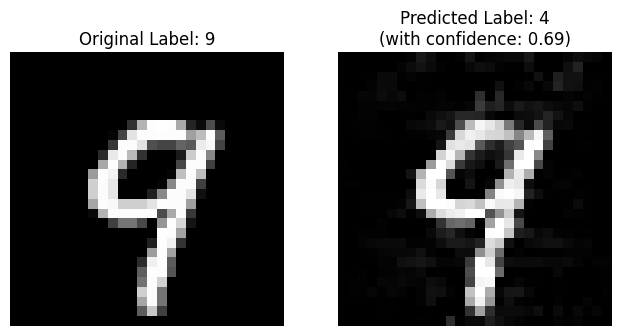

In [77]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the FCN model you created earlier
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_2LFCN.karas")

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(_, _), (test_images, test_labels) = mnist.load_data()
test_images = test_images / 255.0  # Preprocess the data

# Select a random image from the test dataset
random_index = 12  # np.random.randint(0, len(test_images))
input_image = test_images[random_index]
original_label = test_labels[random_index]

# Define an epsilon value for the C&W untargeted attack
epsilon = 0.001
max_iter=50
learning_rate = 0.04

# Use the generate_cw_untargeted function to generate a perturbed image
perturbed_image = generate_carlini_l2(input_image, fcn_model, epsilon, max_iter, learning_rate)

# Calculate the difference between the original and perturbed images
difference_image = input_image - perturbed_image

# Perform inference on the perturbed image
perturbed_image_reshaped = perturbed_image.reshape(1, 28, 28)  # Reshape to match the model's input shape
predictions = fcn_model.predict(perturbed_image_reshaped)

# Get the predicted class label
predicted_label = np.argmax(predictions)
confidence = np.max(predictions)

# Display the original image, perturbed image, and the difference
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(input_image, cmap='gray')
plt.title(f'Original Label: {original_label}')
plt.axis('off')

plt.subplot(132)
plt.imshow(perturbed_image_reshaped[0], cmap='gray')
plt.title(f'Predicted Label: {predicted_label}\n(with confidence: {confidence:.2f})')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 20ms/step


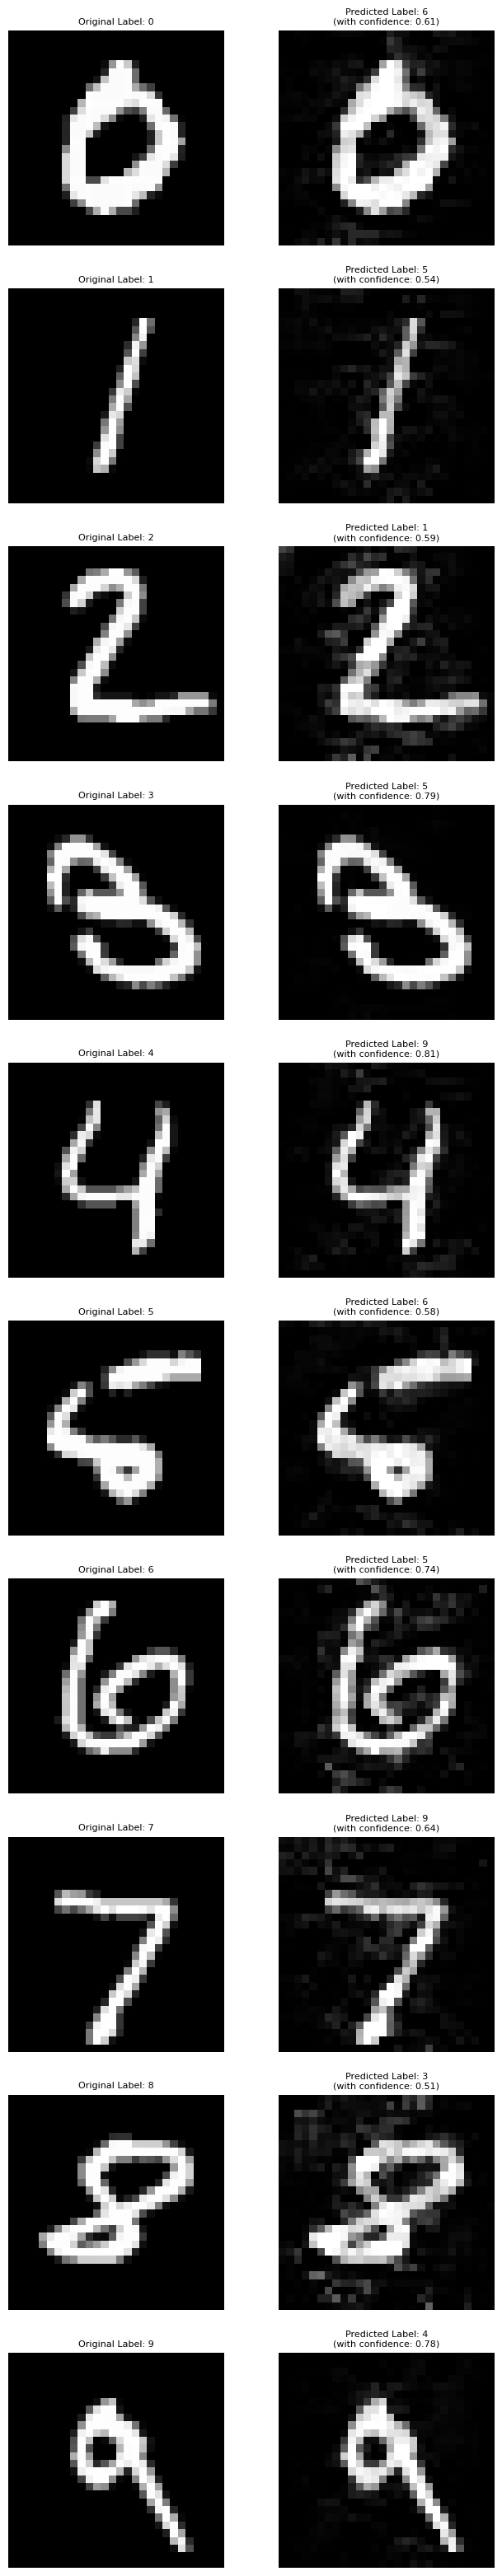

In [78]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the FCN model you created earlier
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_2LFCN.karas")

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(_, _), (test_images, test_labels) = mnist.load_data()
test_images = test_images / 255.0  # Preprocess the data

# Select one sample from each class in the test dataset
indices = []
for i in range(10):  # Assuming there are 10 classes
    indices.append(np.where(test_labels == i)[0][0])

# Define an epsilon value for the FGSM attack
epsilon = 0.25

plt.figure(figsize=(12, 40))

for i, index in enumerate(indices):
    input_image = test_images[index]
    original_label = test_labels[index]

    # Define parameters for the Deepfool attack
    max_iter = 100
    epsilon = 0.001

    # Define an epsilon value for the C&W untargeted attack
    epsilon = 0.001
    max_iter=50
    learning_rate = 0.04

    # Use the generate_cw_untargeted function to generate a perturbed image
    perturbed_image = generate_carlini_l2(input_image, fcn_model, epsilon, max_iter, learning_rate)

    # Calculate the difference between the original and perturbed images
    difference_image = input_image - perturbed_image

    # Perform inference on the perturbed image
    perturbed_image_reshaped = perturbed_image.reshape(1, 28, 28)  # Reshape to match the model's input shape
    predictions = fcn_model.predict(perturbed_image_reshaped)

    # Get the predicted class label
    predicted_label = np.argmax(predictions)
    confidence = np.max(predictions)

    # Display the original image, perturbed image, and the difference
    plt.subplot(10, 3, i*3+1)
    plt.imshow(input_image, cmap='gray')
    plt.title(f'Original Label: {original_label}',fontsize=8)
    plt.axis('off')

    plt.subplot(10, 3, i*3+2)
    plt.imshow(perturbed_image_reshaped[0], cmap='gray')
    plt.title(f'Predicted Label: {predicted_label}\n(with confidence: {confidence:.2f})',fontsize=8)
    plt.axis('off')

plt.show()